In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
files = ["Monday-WorkingHours.pcap_ISCX.csv", #0
         "Tuesday-WorkingHours.pcap_ISCX.csv", #1
         "Wednesday-workingHours.pcap_ISCX.csv", #2
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", #3
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", #4
         "Friday-WorkingHours-Morning.pcap_ISCX.csv", #5
         "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", #6
         "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"] #7

def dataset_file_to_df(index: int, dataset_files: list):
    read_file = f"{dataset_files[index]}"

    df_read = pd.read_csv(read_file)
    df_read.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    return df_read

df0 = dataset_file_to_df(0, files)
df1 = dataset_file_to_df(1, files)
df2 = dataset_file_to_df(2, files)
df3 = dataset_file_to_df(3, files)
df4 = dataset_file_to_df(4, files)
df5 = dataset_file_to_df(5, files)
df6 = dataset_file_to_df(6, files)
df7 = dataset_file_to_df(7, files)

df1 = df1[df1["Label"] != "BENIGN"]
df2 = df2[df2["Label"] != "BENIGN"]
df3 = df3[df3["Label"] != "BENIGN"]
df4 = df4[df4["Label"] != "BENIGN"]
df5 = df5[df5["Label"] != "BENIGN"]
df6 = df6[df6["Label"] != "BENIGN"]
df7 = df7[df7["Label"] != "BENIGN"]

df = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7], axis=0, ignore_index=True)


In [3]:
def normalize(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    df_norm = df.copy()
    for col in numeric_columns:
        if df[col].skew() > 0 or col == "Source Port":
            df_norm[col] = np.log1p(df[col].clip(lower=-0.99))  # Ensures log1p always gets valid input
        elif df[col].skew() < 0:
            df_norm[col] = df[col] ** 2  # Can cause overflow
    return df_norm

df_norm = normalize(df)
df_norm = df_norm[df_norm['Label'] != "Heartbleed"]
df_norm = df_norm[df_norm['Label'] != "Infiltration"]
df_norm['Label'] = df_norm['Label'].apply(lambda x: 'DoS' if x.startswith('DoS') else x)
df_norm['Label'] = df_norm['Label'].apply(lambda x: 'WebAttack' if x.startswith('Web Attack') else x)


In [4]:
X = df_norm.drop(["Flow ID", "Src IP", "Timestamp", "Dst IP", "Label"], axis=1)
y = df_norm["Label"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
print(pd.Series(y_train).value_counts())

Label
BENIGN        370942
DoS           176862
PortScan      111251
DDoS           89619
FTPPatator      5557
SSHPatator      4128
WebAttack       1526
Bot             1376
Name: count, dtype: int64


In [7]:
import pandas as pd
from imblearn.over_sampling import SMOTE

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Major classes: ['BENIGN', 'DoS', 'PortScan', 'DDoS']
Medium classes: ['FTPPatator', 'SSHPatator']
Minor classes: ['WebAttack', 'Bot']
Train class distribution:
 Label
1    90000
0    20000
Name: count, dtype: int64
Test class distribution:
 Label
1    167280
0    158976
Name: count, dtype: int64


In [8]:
print(pd.Series(y_train).value_counts())

Label
1    90000
0    20000
Name: count, dtype: int64


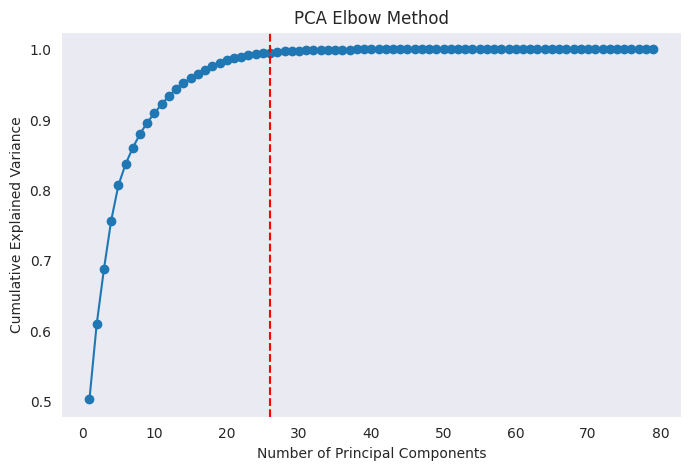

Optimal number of components: 26


In [9]:
pca = PCA()

pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.001) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

In [10]:
pca = PCA(n_components=elbow_point)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### LinearSVC

In [118]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


model = LinearSVC(dual=False)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [1000, 5000, 10000]
}

# Grid Search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność:", grid_search.best_score_)


/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converg

Najlepsze parametry: {'C': 100, 'max_iter': 1000, 'penalty': 'l2'}
Najlepsza dokładność: 0.8460066372375118


In [121]:
linear_svc = grid_search.best_estimator_

y_pred = linear_svc.predict(X_test_pca)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.77      0.86    158976
           1       0.82      0.99      0.89    167280

    accuracy                           0.88    326256
   macro avg       0.90      0.88      0.88    326256
weighted avg       0.90      0.88      0.88    326256



### SVM

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


model = SVC()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
}
# Grid Search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność:", grid_search.best_score_)

Najlepsze parametry: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Najlepsza dokładność: 0.9617246442147899


In [14]:
best_svc = grid_search.best_estimator_
y_pred_svm = best_svc.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88    158976
           1       0.84      1.00      0.91    167280

    accuracy                           0.90    326256
   macro avg       0.92      0.90      0.90    326256
weighted avg       0.91      0.90      0.90    326256



### Binary DecisionTreeClassifier

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

model = DecisionTreeClassifier()

param_dist = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": [None, "sqrt", "log2"]
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=50,
    cv=3, scoring="f1_macro", n_jobs=-1, random_state=42
)

random_search.fit(X_train_pca, y_train)

print("Najlepsze parametry:", random_search.best_params_)
print("Najlepszy wynik:", random_search.best_score_)


Najlepsze parametry: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 10, 'splitter': 'best'}
Najlepszy wynik: 0.8416766166793882


In [11]:
from sklearn.metrics import classification_report
y_pred_dt = random_search.best_estimator_.predict(X_test_pca)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92    158976
           1       0.88      0.98      0.93    167280

    accuracy                           0.93    326256
   macro avg       0.93      0.92      0.93    326256
weighted avg       0.93      0.93      0.93    326256



### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder

param_dist = {
    'n_neighbors': randint(3, 30),  # Wider range, more flexibility
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': randint(1, 5)  # Allows exploration beyond just 1 (Manhattan) and 2 (Euclidean)
}

model = KNeighborsClassifier()

knn_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=3, scoring="f1_macro", n_jobs=-1, random_state=42)

knn_search.fit(X_train_pca, y_train)

print("Najlepsze parametry:", knn_search.best_params_)


Najlepsze parametry: {'metric': 'manhattan', 'n_neighbors': 29, 'p': 3, 'weights': 'uniform'}


In [16]:
y_pred = knn_search.best_estimator_.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    158976
           1       0.97      1.00      0.99    167280

    accuracy                           0.99    326256
   macro avg       0.99      0.99      0.99    326256
weighted avg       0.99      0.99      0.99    326256



### SDGClassifier

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = SGDClassifier(random_state=42)

param_grid = [
    {
        "loss": ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
        "penalty": ["l2", "l1"],
        "alpha": [1e-2, 1e-1, 1],
        "learning_rate": ["optimal"],
        "eta0": [1e-3, 1e-2, 1e-1],
        "max_iter": [5000, 10000],
        "tol": [1e-3],
        "class_weight": [None],
    },
    {
        "loss": ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
        "penalty": ["elasticnet"],
        "eta0": [1e-5, 1e-4, 1e-3, 1e-2],
        "alpha": [1e-2, 1e-1, 1],
        "l1_ratio": [0.15, 0.5, 0.85],
        "learning_rate": ["optimal"],
        "max_iter": [5000, 10000],
        "tol": [1e-3],
        "class_weight": [None],
    }
]



grid = GridSearchCV(clf, param_grid, scoring="f1_macro", cv=3, n_jobs=-1)
grid.fit(X_train_pca, y_train)

print(grid.best_params_)

/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteratio

{'alpha': 0.1, 'class_weight': None, 'eta0': 1e-05, 'l1_ratio': 0.5, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 10000, 'penalty': 'elasticnet', 'tol': 0.001}


/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [12]:
sdg_model = grid.best_estimator_
print("Najlepsze parametry:", grid.best_params_)
y_pred = sdg_model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

Najlepsze parametry: {'alpha': 0.1, 'class_weight': None, 'eta0': 1e-05, 'l1_ratio': 0.5, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 10000, 'penalty': 'elasticnet', 'tol': 0.001}
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    158976
           1       0.75      0.99      0.86    167280

    accuracy                           0.83    326256
   macro avg       0.87      0.82      0.82    326256
weighted avg       0.87      0.83      0.82    326256

